# Compiled Code


In [24]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'bright'])
import os
os.chdir('/Users/acannon/Dropbox')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

## DATA

In [25]:
google_trends = pd.read_excel('diss_data/std trends.xlsx')
more_indicators = pd.read_excel('diss_data/more indicators.xlsx', sheet_name='Sheet2')
more_indicators = more_indicators.iloc[:,:11]
nipo = pd.read_excel('diss_data/equity_issue04.xlsx', sheet_name = 'eq_ipo')
MA = pd.read_excel('diss_data/MA_approved.xlsx')

more_indicators.head()

,Date,period,land_sales_volume,all_vacancies,vacancy_ratio,new_cars,Y10,m7,spread,crude,crude_volume
0,01/31/04,2004-01,NaN,2.30,2.40,,,NaN,NaN,NaN,NaN
1,02/29/04,2004-02,NaN,2.30,2.30,91.46,,NaN,NaN,NaN,NaN
2,03/31/04,2004-03,NaN,2.30,2.30,466.96,4.72,NaN,NaN,31.51,933112
3,04/30/04,2004-04,NaN,2.30,2.30,187,4.96,NaN,NaN,34.48,933233
4,05/31/04,2004-05,NaN,2.40,2.30,194.48,5.11,4.26,0.85,36.58,918837


In [26]:
print(google_trends.describe(percentiles = [0.5]).transpose().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  count &   mean &   std &   min &    50\% &    max \\
\midrule
Benefits       & 241.00 &  43.74 & 17.63 & 14.00 &  45.00 & 100.00 \\
Indeed         & 241.00 &  36.60 & 32.44 &  0.00 &  42.00 & 100.00 \\
Linkedin       & 241.00 &  43.76 & 28.52 &  0.00 &  55.00 &  88.00 \\
SkyScanner     & 241.00 &  36.43 & 27.06 &  1.00 &  30.00 & 100.00 \\
Emirates       & 241.00 &  61.07 & 15.52 & 13.00 &  63.00 & 100.00 \\
Holiday        & 241.00 &  48.46 & 15.50 & 18.00 &  48.00 & 100.00 \\
Film           & 241.00 &  74.95 &  9.67 & 55.00 &  74.00 & 100.00 \\
DIY            & 241.00 &  50.77 & 13.38 & 27.00 &  48.00 & 100.00 \\
Gifts          & 242.00 &  32.34 & 17.90 & 15.00 &  27.00 & 100.00 \\
Clothes        & 242.00 &  67.60 &  9.68 & 48.00 &  67.00 & 100.00 \\
Jobs           & 242.00 &  70.64 & 12.48 & 41.00 &  69.50 & 100.00 \\
Merc           & 242.00 &  47.49 & 16.78 & 23.00 &  48.00 & 100.00 \\
Toyota         & 242.00 &  72.31 & 10.47 & 40.00 &  72.00 

In [27]:
print(more_indicators[['land_sales_volume', 'new_cars', 'Y10', 'm7', 'spread', 'crude']].describe(percentiles = [0.5]).transpose().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  count &  mean &  std &   min &  50\% &  max \\
\midrule
spread & 235.00 &  1.02 & 1.28 & -1.71 & 0.93 & 5.00 \\
\bottomrule
\end{tabular}



In [28]:
print(nipo.describe(percentiles = [0.5]).transpose().to_latex())


\begin{tabular}{lrrrrrr}
\toprule
{} &  count &  mean &   std &  min &   50\% &   max \\
\midrule
count        & 243.00 & 42.91 & 14.74 & 3.00 & 43.00 & 99.00 \\
equity\_count & 243.00 & 42.91 & 14.74 & 3.00 & 43.00 & 99.00 \\
ipo\_count    & 223.00 &  7.94 &  6.55 & 1.00 &  6.00 & 34.00 \\
\bottomrule
\end{tabular}



In [29]:
print(MA.describe(percentiles = [0.5]).transpose().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  count &  mean &   std &  min &   50\% &   max \\
\midrule
Deal Count & 243.00 & 22.86 & 11.14 & 3.00 & 21.00 & 63.00 \\
\bottomrule
\end{tabular}



## Pillar 2 - Retail Sentiment

Creating the data points for the google trends data. I standardise the data in STATA, and conduct the PCA to get the rotations.
This is hard coded, and i do not know how to save the rotations as a string or something (need to fix)

In [30]:
gt = pd.read_excel('diss_data/std trends.xlsx')
gt = gt.filter(regex= "std")

january_indices = [i for i in range(230) if gt.index[i] % 12 == 0]
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

print(gt.describe().to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  std\_Benefits &  std\_Indeed &  std\_Linkedin &  std\_SkyScanner &  std\_Emirates &  std\_Holiday &  std\_Film &  std\_DIY &  std\_Gifts &  std\_Clothes &  std\_Jobs &  std\_Merc &  std\_Toyota &  std\_Resort &  std\_RyanAir &  std\_Museums &  std\_McD &  std\_Gucci &  std\_LV &  std\_Zara &  std\_fm \\
\midrule
count &        241.00 &      241.00 &        241.00 &          241.00 &        241.00 &       241.00 &    241.00 &   241.00 &     242.00 &       242.00 &    242.00 &    242.00 &      242.00 &      242.00 &       242.00 &       242.00 &   242.00 &     242.00 &  242.00 &    242.00 &  242.00 \\
mean  &          0.00 &        0.00 &          0.00 &           -0.00 &          0.00 &         0.00 &     -0.00 &     0.00 &       0.00 &         0.00 &     -0.00 &     -0.00 &       -0.00 &       -0.00 &        -0.00 &        -0.00 &     0.00 &       0.00 &   -0.00 &      0.00 &   -0.00 \\
std   &          1.00 &        1.00 &        

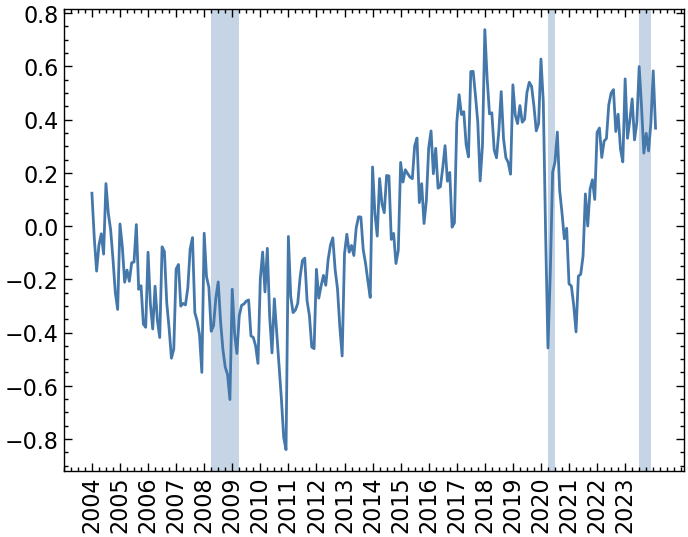

In [31]:
gt['trends'] = gt.mean(axis = 1)
plt.plot(gt['trends'], label = 'Google Trends')
plt.xticks(january_indices, years, rotation = 'vertical')
plt.axvspan(51, 63, alpha = 0.3)
plt.axvspan(195, 198, alpha = 0.3)
plt.axvspan(234, 239, alpha = 0.3)
plt.show()

In [32]:
p2 = pd.DataFrame()
p2['indicator2'] = gt['trends']

## Pillar 3 - LTP


In [33]:
indicators = pd.read_excel('diss_data/more.xlsx')

# getting the long-term purchase variables from the indicator dataset

ltp = indicators[['period', 'std_resid_land', 'std_resid_car']]

# making them numeric because they are strings atm
ltp['std_resid_car'] = pd.to_numeric(ltp['std_resid_car'], errors = 'coerce')
ltp['std_resid_land'] = pd.to_numeric(ltp['std_resid_land'], errors = 'coerce')

# calculate percentage change
ltp['car_pct'] = ltp['std_resid_car'].pct_change()
ltp['land_pct'] = ltp['std_resid_land'].pct_change()
ltp['car_diff'] = ltp['std_resid_car'].diff()
ltp['land_diff'] = ltp['std_resid_land'].diff()

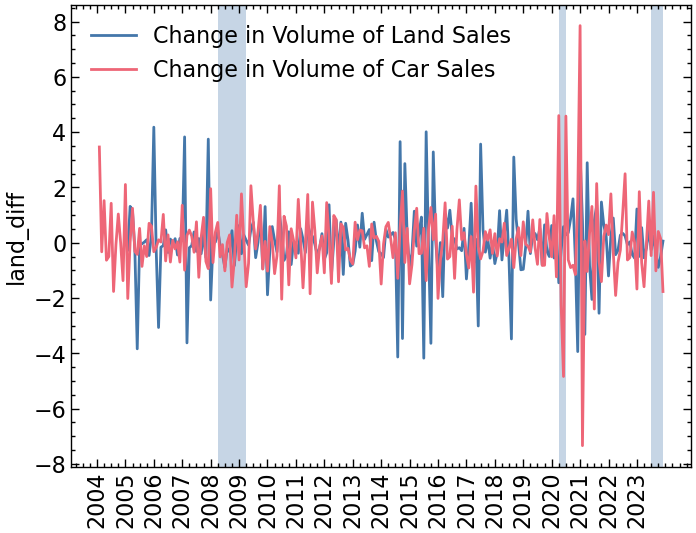

In [34]:
sns.lineplot(ltp['land_diff'], label = 'Change in Volume of Land Sales')
sns.lineplot(ltp['car_diff'], label = 'Change in Volume of Car Sales')
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession')
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.show()

Adding the recession highlights just to get a better grasp of how the pct change in monthly change may tell us something about upcoming recessions. In the case of 2020 and 2023 there seems to be drops before the *actual* recession hits. This is not the case for 2008-9, but again we see a massive drop off about 2 years in advance (no idea what to interpret from that). The shocks in this during 2006ish and 2014ish may be do to some exogenous shocks that I am unaware of.

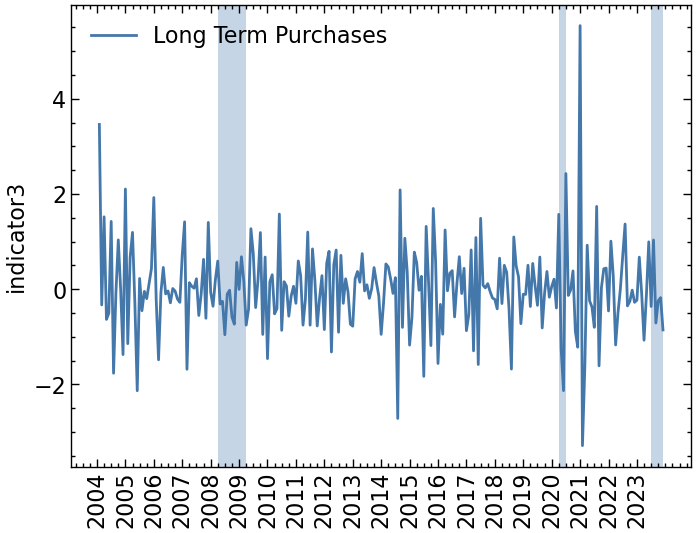

In [35]:
p3 = ltp[['car_diff','land_diff']]

p3['indicator3'] = p3[['land_diff', 'car_diff']].mean(1,skipna=True)
p3['period'] = ltp['period']

sns.lineplot(p3['indicator3'], label = 'Long Term Purchases')
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession')
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.show()

In [36]:
p3.describe()
p3_std = pd.DataFrame(scaler.fit_transform(p3[['land_diff', 'car_diff']]), columns = ['land_diff', 'car_diff'])
p3_std['indicator3'] = p3_std.mean(axis = 1)
p3_std = pd.DataFrame(scaler.fit_transform(p3_std[['land_diff', 'car_diff', 'indicator3']]), columns = ['land_diff', 'car_diff', 'indicator3'])
p3_std.describe()

,land_diff,car_diff,indicator3
count,227.00,239.00,239.00
mean,0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-3.24,-5.62,-3.49
25%,-0.33,-0.51,-0.46
50%,0.02,0.01,-0.04
75%,0.38,0.44,0.50
max,3.25,5.99,5.88


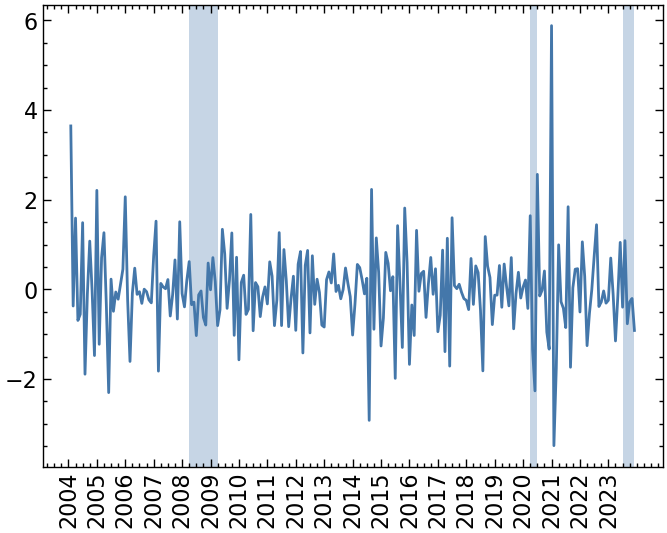

In [37]:
plt.plot(p3_std['indicator3'], label = 'Long Term Purchases')
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession')
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.show()

# Pillar 4

<AxesSubplot:ylabel='spread'>

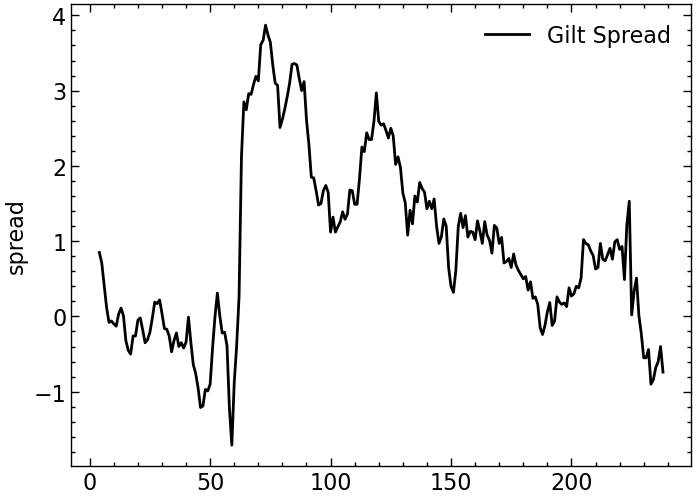

In [38]:
spread = indicators[['Y10', 'month2']]
spread['Y10'] = pd.to_numeric(spread['Y10'], errors= 'coerce')
spread['spread'] = spread['Y10'] - spread['month2']
spread['period'] = indicators['period']

sns.lineplot(spread['spread'], label = 'Gilt Spread', color = 'black')

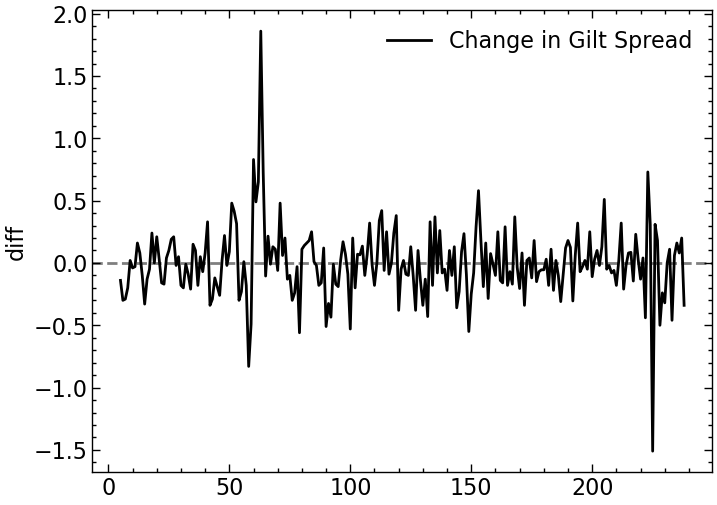

In [39]:
spread['diff'] = spread['spread'].diff()

sns.lineplot(spread['diff'], color = 'black', label = 'Change in Gilt Spread')
plt.axhline(y = 0, alpha = 0.5, linestyle = 'dashed', color = 'black')

In [40]:
ftse = pd.read_excel('diss_data/ftse_data.xlsx', sheet_name= 'ftse_data')

print(ftse.describe(percentiles = [0.5]).transpose().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  count &     mean &      std &      min &      50\% &       max \\
\midrule
III LN Equity  & 242.00 &   723.99 &   461.55 &   124.54 &   622.27 &  2,479.00 \\
ADM LN Equity  & 234.00 & 1,586.58 &   715.25 &   288.00 & 1,508.50 &  3,611.00 \\
AAF LN Equity  &  65.00 &   238.59 &   382.25 &    34.00 &   109.60 &  1,376.54 \\
AAL LN Equity  & 242.00 & 1,990.74 &   769.44 &   276.16 & 1,888.68 &  3,972.50 \\
ANTO LN Equity & 242.00 &   872.81 &   398.41 &   180.00 &   835.25 &  1,865.50 \\
AHT LN Equity  & 242.00 & 1,449.60 & 1,729.53 &    22.28 &   826.75 &  6,124.00 \\
ABF LN Equity  & 242.00 & 1,733.37 &   859.00 &   563.00 & 1,757.00 &  3,546.00 \\
AZN LN Equity  & 242.00 & 4,795.87 & 2,684.14 & 1,884.00 & 3,867.50 & 11,746.00 \\
AUTO LN Equity & 116.00 &   514.20 &   129.50 &   251.75 &   534.10 &    748.68 \\
AV/ LN Equity  & 242.00 &   606.72 &   183.74 &   284.54 &   569.80 &  1,081.58 \\
BME LN Equity  & 125.00 &   387.62 &   113.99 &   164.5

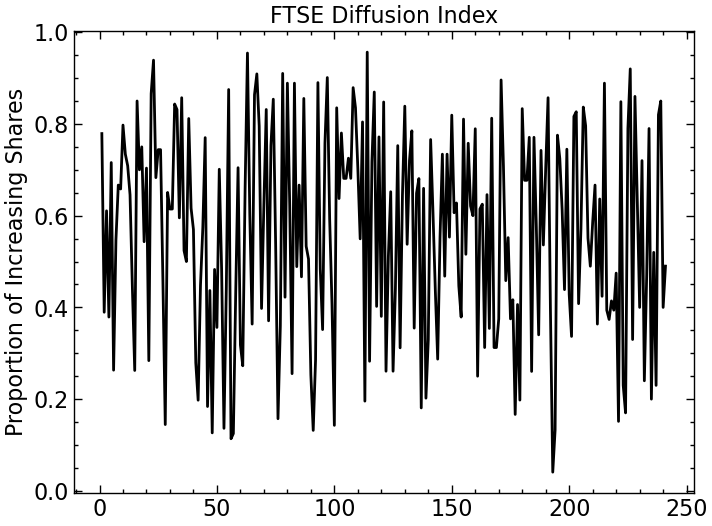

In [85]:

# ftse_up = ftse.reindex(index = ftse.index[::-1])
ftse_nd = ftse.loc[:,ftse.columns !='DATE']
ftse_diff = ftse_nd.diff()
ftse_diff['count'] = ftse_diff.notna().sum(axis = 1)
ftse_diff['pos'] = (ftse_diff>0).sum(axis = 1)
ftse_diff['count'][0] = np.nan
ftse_diff['ftse_index'] = ftse_diff['pos']/ftse_diff['count']
ftse_diff['DATE'] = ftse['DATE']

sns.lineplot(ftse_diff['ftse_index'], color = 'black')
plt.ylabel('Proportion of Increasing Shares')
plt.title('FTSE Diffusion Index')
plt.show()

In [42]:
print(ftse_diff['ftse_index'][1])

0.7789473684210526


In [43]:
ndx = pd.read_excel('diss_data/ndx_data.xlsx', sheet_name= 'Sheet2')

print(ndx.describe(percentiles = [0.5]).transpose().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  count &      mean &       std &      min &       50\% &        max \\
\midrule
MSFT US Equity  & 241.00 &  6,845.66 &  7,989.52 & 1,125.67 &  2,330.40 &  32,234.14 \\
AAPL US Equity  & 241.00 &  3,368.14 &  4,374.55 &    22.89 &  1,348.15 &  15,278.43 \\
NVDA US Equity  & 241.00 &  4,545.10 &  9,096.33 &    57.55 &    319.20 &  62,376.41 \\
AMZN US Equity  & 241.00 &  3,518.60 &  4,234.54 &    71.97 &    992.36 &  13,802.85 \\
GOOG US Equity  & 120.00 &  5,418.67 &  3,045.63 & 1,556.39 &  4,535.76 &  11,149.55 \\
GOOGL US Equity & 235.00 &  3,156.20 &  3,166.71 &   141.99 &  1,709.36 &  11,015.88 \\
META US Equity  & 142.00 & 12,221.44 &  7,651.58 & 1,138.30 & 12,180.34 &  38,365.51 \\
TSLA US Equity  & 165.00 &  5,631.74 &  8,076.41 &    84.66 &  1,236.29 &  28,768.60 \\
AVGO US Equity  & 175.00 & 19,093.19 & 20,188.68 &   912.41 & 13,925.42 & 102,392.11 \\
ASML US Equity  & 241.00 & 13,602.06 & 17,901.26 &   799.14 &  5,625.12 &  74,422.09 \\
C

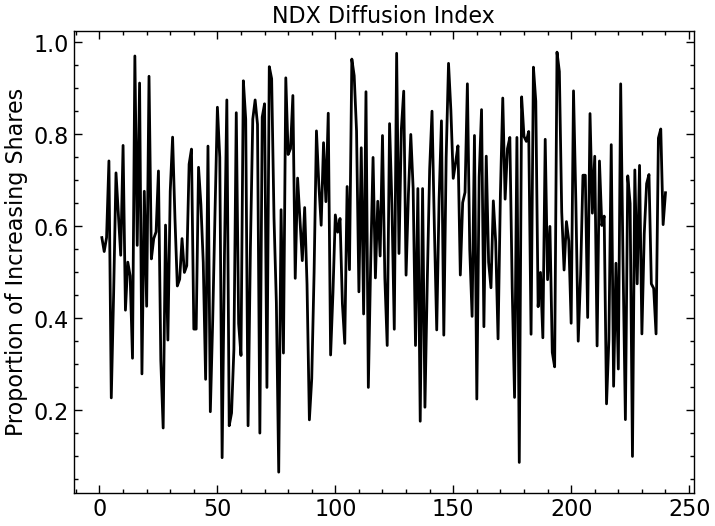

In [84]:
# ftse_up = ftse.reindex(index = ftse.index[::-1])
ndx_nd = ndx.iloc[:, 1:]
ndx_diff = ndx_nd.diff()
ndx_diff['count'] = ndx_diff.notna().sum(axis = 1)
ndx_diff['pos'] = (ndx_diff>0).sum(axis = 1)
ndx_diff['count'][0] = np.nan
ndx_diff['ndx_index'] = ndx_diff['pos']/ndx_diff['count']
ndx_diff['DATE'] = ndx['DATE']

sns.lineplot(ndx_diff['ndx_index'], color = 'black')
plt.ylabel('Proportion of Increasing Shares')
plt.title('NDX Diffusion Index')
plt.show()

In [45]:
merged_df = pd.merge(ndx_diff[['ndx_index']], ftse_diff[['ftse_index']], left_index=True, right_index=True)



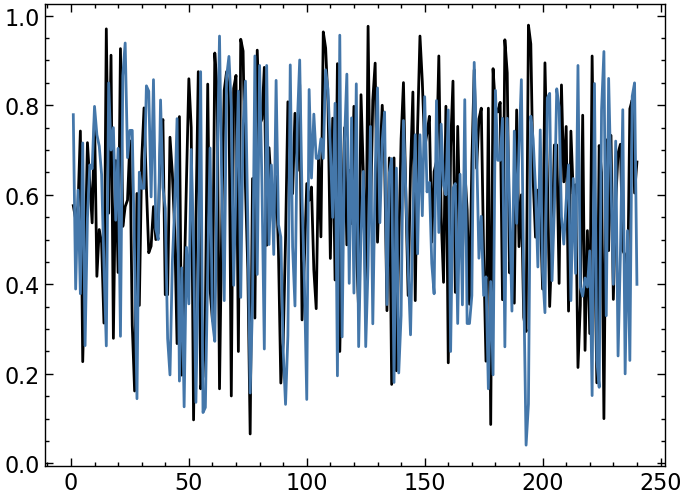

In [81]:
plt.plot(merged_df['ndx_index'], label = 'Nasdaq', color = 'black')
plt.plot(merged_df['ftse_index'], label = 'FTSE')
plt.show()

In [48]:
nipo = pd.read_excel('diss_data/equity_issue04.xlsx', sheet_name='eq_ipo')
nipo['ipo_count'] = nipo['ipo_count'].astype(int, errors = 'ignore')

# replace all empty cells with 0
if nipo['ipo_count'].isnull().values.any():
    nipo['ipo_count'] = nipo['ipo_count'].fillna(0)

nipo_12 = nipo['ipo_count'].rolling(12).mean()
nipo_ewm = nipo['ipo_count'].ewm(alpha = 0.1).mean()

df_nipo = pd.DataFrame()
df_nipo['ipo_count'] = nipo['ipo_count']
df_nipo['nipo12'] = nipo_12
df_nipo['nipo_ewm'] = nipo_ewm

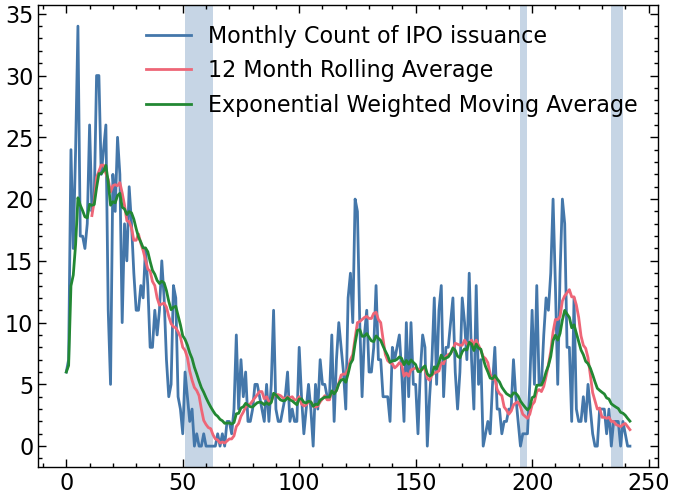

In [49]:
plt.plot(nipo['ipo_count'], label = 'Monthly Count of IPO issuance')
plt.plot(nipo_12, label = '12 Month Rolling Average')
plt.plot(nipo_ewm, label = 'Exponential Weighted Moving Average')
plt.axvspan(51, 63, alpha = 0.3)
plt.axvspan(195, 198, alpha = 0.3)
plt.axvspan(234, 239, alpha = 0.3)
plt.legend(loc = 'upper right')
plt.show()

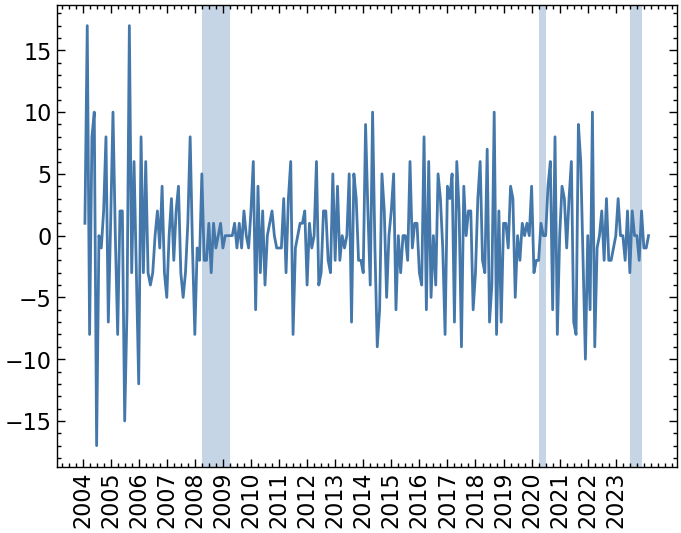

In [50]:
nipo['ipo_change'] = nipo['ipo_count'].diff()
plt.plot(nipo['ipo_change'])
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession')
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.show()

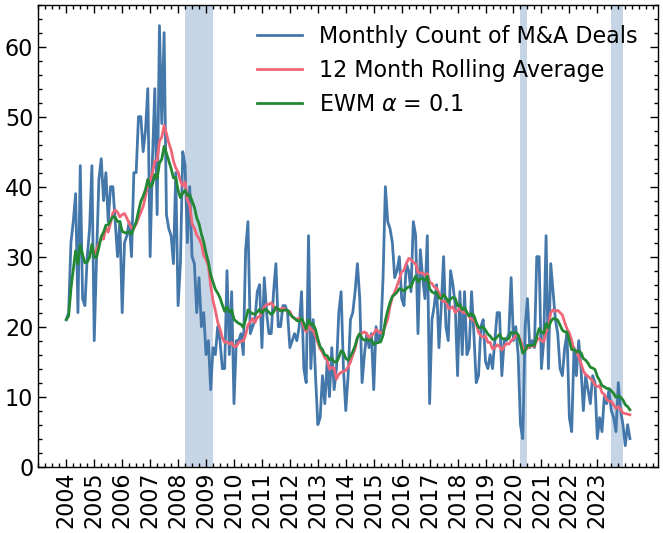

In [51]:
MA.head()
MA['12count'] = MA['Deal Count'].rolling(12).mean()

MA['count_ewm'] = MA['Deal Count'].ewm(alpha = 0.1).mean()

plt.plot(MA['Deal Count'], label = 'Monthly Count of M&A Deals')
plt.plot(MA['12count'], label = '12 Month Rolling Average')
plt.plot(MA['count_ewm'], label = r'EWM $\alpha$ = 0.1')
plt.axvspan(51, 63, alpha = 0.3)
plt.axvspan(195, 198, alpha = 0.3)
plt.axvspan(234, 239, alpha = 0.3)
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.legend(loc = 'upper right')
plt.show()

In [52]:
df_nipo.head()
std_ipo = pd.DataFrame(scaler.fit_transform(df_nipo[['ipo_count', 'nipo12', 'nipo_ewm']]), columns = [['nipo', 'nipo_12', 'nipo_ewm']])
std_ma = pd.DataFrame(scaler.fit_transform(MA[['Deal Count', '12count', 'count_ewm']]), columns = [['ma', 'ma_12', 'ma_ewm']])

In [53]:
p4 = spread[['period','spread', 'diff']]
p4['FTSE'] = ftse_diff['ftse_index']
p4['FTSE'] = p4['FTSE'] - 0.5
p4['NDX'] = ndx_diff['ndx_index']
p4['NDX'] = p4['NDX'] - 0.5
p4['ipo'] = std_ipo['nipo'].diff()
p4['ipo_12'] = std_ipo['nipo_12']
p4['ipo_ewm'] = std_ipo['nipo_ewm']
p4['ma'] = std_ma['ma'].diff()
p4['ma_12'] = std_ma['ma_12']
p4['ma_ewm'] = std_ma['ma_ewm']
p4['indicator4'] = p4[['diff', 'FTSE', 'NDX', 'ipo', 'ma']].mean(1, skipna=True) 


No handles with labels found to put in legend.


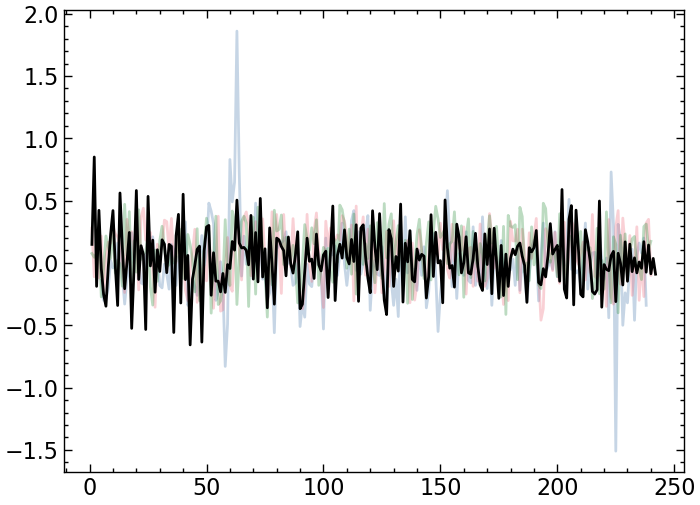

In [54]:


plt.plot(p4['diff'], alpha = 0.3)
plt.plot(p4['FTSE'], alpha = 0.3)
plt.plot(p4['NDX'], alpha = 0.3)
#plt.plot(p4['ipo_12'], alpha = 0.3, label = 'ipo')
#plt.plot(p4['ma_12'], alpha = 0.3, label = 'ma')
plt.plot(p4['indicator4'], color = 'black')
plt.legend(loc = 'upper right')
plt.show()

In [55]:
p4_std = pd.DataFrame(scaler.fit_transform(p4[['diff', 'FTSE', 'NDX', 'ipo_12', 'ma_12']]), columns = [['diff', 'FTSE', 'NDX', 'ipo_12', 'ma_12']])
p4_std['indicator4'] = p4_std.mean(axis = 1, skipna = True)
p4_std = pd.DataFrame(scaler.fit_transform(p4[['diff', 'FTSE', 'NDX', 'ipo_12', 'ma_12', 'indicator4']]), columns = [['diff', 'FTSE', 'NDX', 'ipo_12', 'ma_12', 'indicator4']])


In [56]:
print(p4.describe().to_latex()) 
print()
print(p4_std.describe().to_latex()) 

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  spread &   diff &   FTSE &    NDX &    ipo &  ipo\_12 &  ipo\_ewm &     ma &  ma\_12 &  ma\_ewm &  indicator4 \\
\midrule
count &  235.00 & 234.00 & 241.00 & 240.00 & 242.00 &  232.00 &   243.00 & 242.00 & 232.00 &  243.00 &      242.00 \\
mean  &    0.93 &  -0.01 &   0.06 &   0.09 &  -0.00 &   -0.00 &     0.00 &  -0.01 &   0.00 &   -0.00 &        0.03 \\
std   &    1.19 &   0.29 &   0.22 &   0.22 &   0.71 &    1.00 &     1.00 &   0.75 &   1.00 &    1.00 &        0.24 \\
min   &   -1.71 &  -1.51 &  -0.46 &  -0.43 &  -2.57 &   -1.33 &    -1.15 &  -2.34 &  -1.75 &   -1.90 &       -0.66 \\
25\%   &   -0.01 &  -0.17 &  -0.11 &  -0.07 &  -0.45 &   -0.69 &    -0.75 &  -0.45 &  -0.60 &   -0.66 &       -0.13 \\
50\%   &    0.84 &  -0.02 &   0.10 &   0.11 &   0.00 &   -0.25 &    -0.25 &   0.00 &  -0.23 &   -0.22 &        0.03 \\
75\%   &    1.62 &   0.13 &   0.25 &   0.27 &   0.30 &    0.46 &     0.22 &   0.45 &   0.52 &    0.44 &        0.16 \\
max 

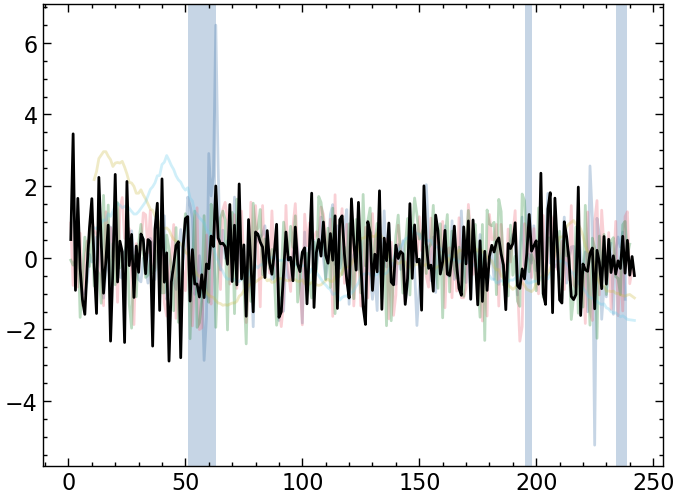

In [57]:
plt.plot(p4_std['diff'], alpha = 0.3)
plt.plot(p4_std['FTSE'], alpha = 0.3)
plt.plot(p4_std['NDX'], alpha = 0.3)
plt.plot(p4_std['ipo_12'], alpha = 0.3, label = 'ipo')
plt.plot(p4_std['ma_12'], alpha = 0.3, label = 'ma')
plt.plot(p4_std['indicator4'], color = 'black')
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession')

In [58]:
p4_std['indicator4_12'] = p4_std['indicator4'].rolling(6).mean()


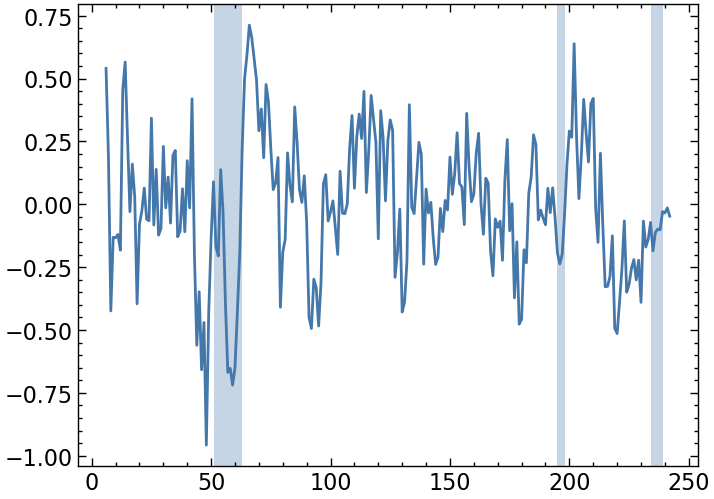

In [59]:
plt.plot(p4_std['indicator4_12'], label = '12 Month Rolling Average')
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession')

# Pillar 5

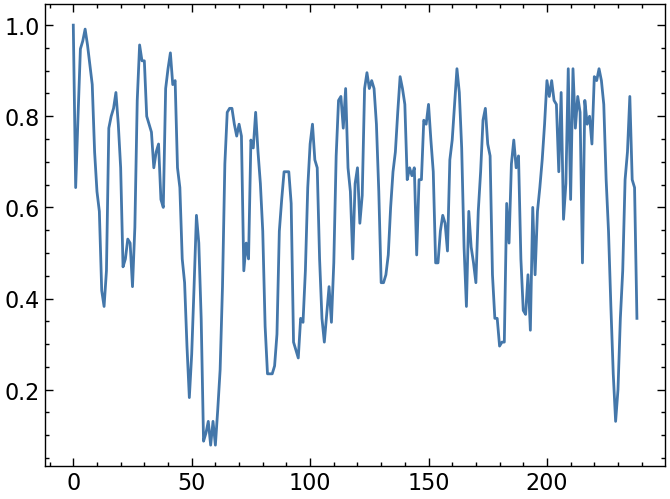

In [60]:
df_hp = pd.read_excel('diss_data/clean_hp.xlsx')
pdummy = df_hp.filter(regex = "Ip$")

pdummy.head()

diff_index = pdummy.mean(axis = 1)
diff_index.plot.line(x = df_hp['period'])

diff_diff_hp = diff_index.diff()

<AxesSubplot:>

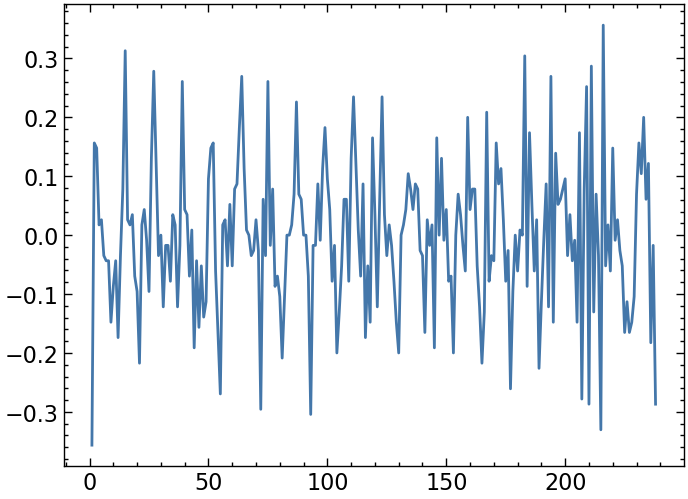

In [61]:
sns.lineplot(diff_diff_hp)

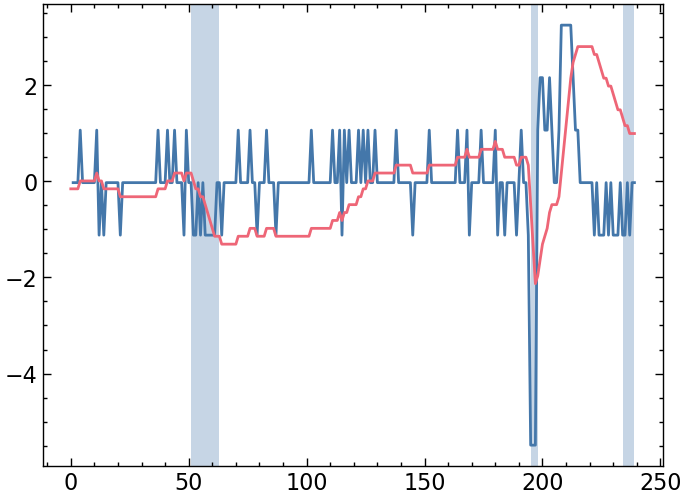

In [62]:
p5 = pd.DataFrame()
p5['vacancy'] = indicators[['all_vacancies']]
p5['vac_diff'] = p5['vacancy'].diff()
p5['period'] = indicators['period']


std_p5 = pd.DataFrame(scaler.fit_transform(p5[['vacancy','vac_diff']]), columns = [['vacancy','vac_diff']])

plt.plot(std_p5['vac_diff'])
plt.plot(std_p5['vacancy'])
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession')

<AxesSubplot:ylabel='indicator5'>

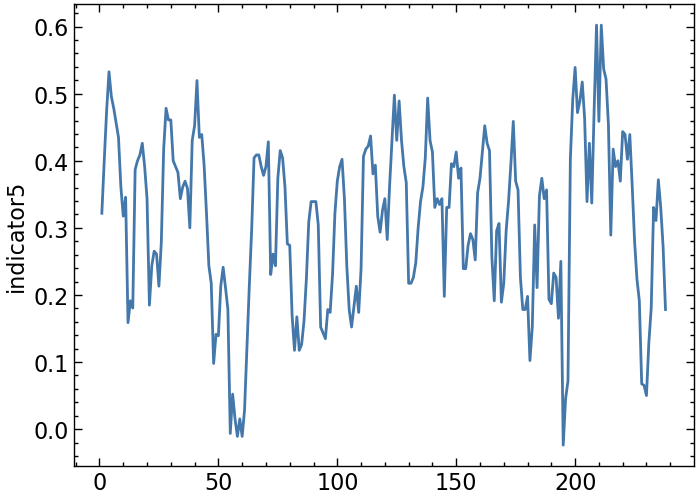

In [63]:
p5['diff_index'] = diff_index # testing the differenced diffusion index rather than level, change back to diff diff hp

p5['indicator5'] = 0.5 * p5['diff_index'] + 0.5 * p5['vac_diff']
sns.lineplot(p5['indicator5'])

## Constructing the Sentiment Index

In [64]:
frames = [p3,p4,p5]
SI = p4.merge(p5, how = 'left', on = 'period')
SI = SI.merge(p3, 'left', on = 'period')

In [65]:
SI.head()
SI = SI.filter(regex = r'indicator')
SI['period'] = p5['period'] 
SI['indicator2'] = gt['trends']

In [66]:
SI['final'] = SI[['indicator2','indicator3','indicator4','indicator5']].mean(1, skipna=True)

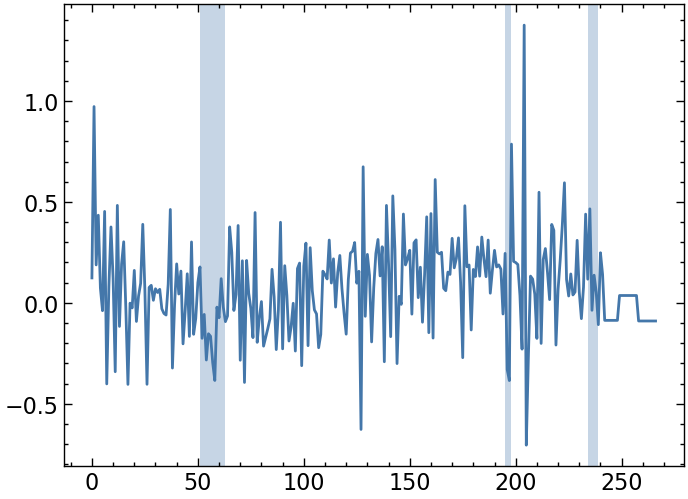

In [67]:
SI['final'].plot()
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession')

In [68]:

std_SI = pd.DataFrame(scaler.fit_transform(SI[['indicator2','indicator3','indicator4','indicator5']]), columns = [['indicator2','indicator3','indicator4','indicator5']])
std_SI['final'] = std_SI[['indicator2','indicator3','indicator4','indicator5']].mean(1, skipna=True)
std_SI['period'] = SI['period']


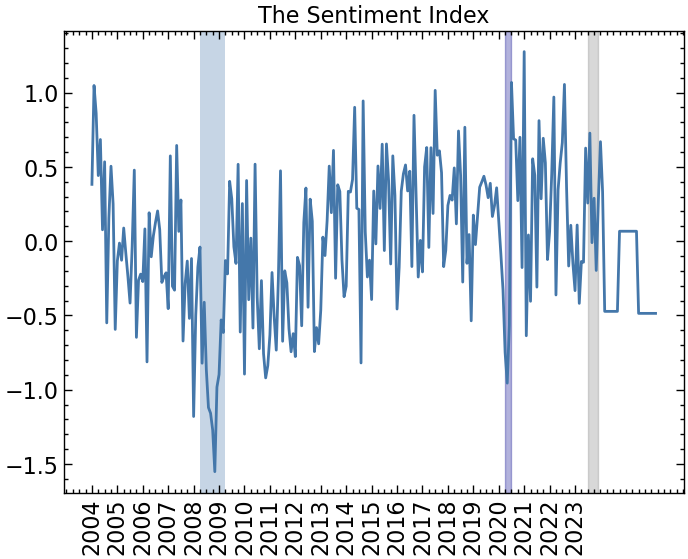

In [69]:

plt.plot(std_SI['final'], label = 'Sentiment Index')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.title('The Sentiment Index')


# trying to add grey area for recessions
# index 0 is 2004 - 01
# 2008-01 == 48
# 2008-04 == 51
# 2008 Q2 (51) - 2009 Q2 (63)
# 2020 Q1 (195) - Q2 (198)
# 2023 Q3 (234) - Q4 (239)
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
plt.show()

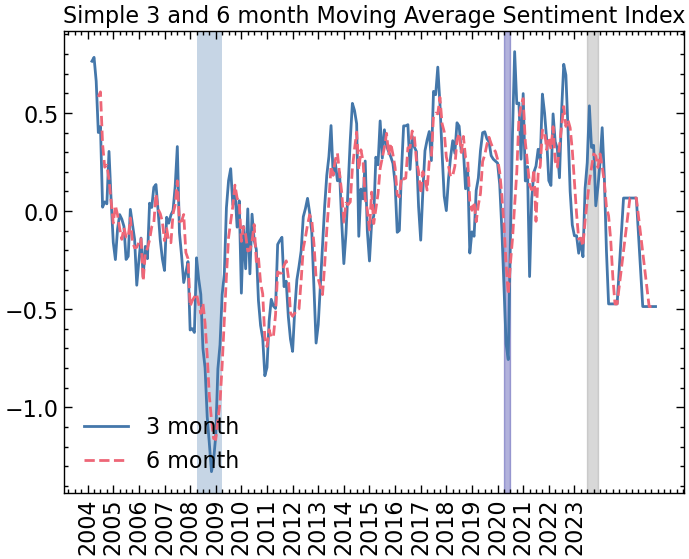

In [70]:

sma3 = std_SI['final'].rolling(3).mean()
sma6 = std_SI['final'].rolling(6).mean()
plt.plot(sma3, label = '3 month')
plt.plot(sma6, label = '6 month', linestyle = 'dashed')
plt.axvspan(51, 63, alpha = 0.3)
plt.axvspan(195, 198, alpha = 0.3, color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, color = 'grey')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.title('Simple 3 and 6 month Moving Average Sentiment Index')
plt.legend(loc = 'lower left')
plt.show()

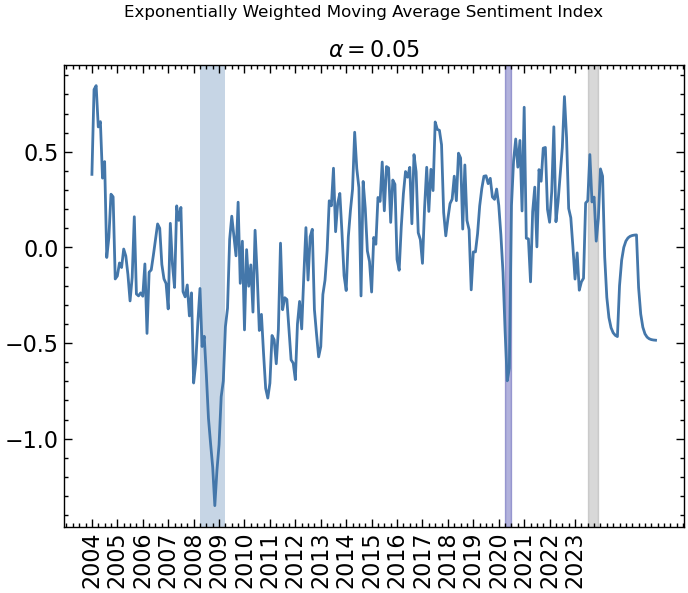

In [71]:
ema = std_SI['final'].ewm(alpha = 0.5).mean()
plt.plot(ema)
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
plt.suptitle('Exponentially Weighted Moving Average Sentiment Index')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.title(r'$\alpha = 0.05$')
plt.show()

In [72]:
std_SI[['indicator2', 'indicator3','indicator4', 'indicator5']].describe()

,indicator2,indicator3,indicator4,indicator5
count,242.00,239.00,266.00,238.00
mean,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-2.61,-3.52,-2.97,-2.65
25%,-0.77,-0.46,-0.56,-0.74
50%,-0.12,-0.05,-0.03,0.22
75%,0.89,0.50,0.56,0.74
max,2.29,5.89,3.63,2.31


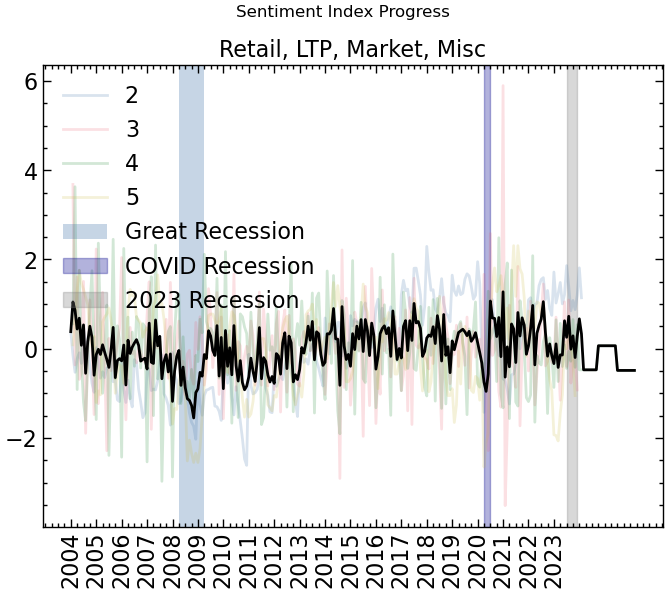

In [73]:
plt.plot(std_SI['indicator2'], alpha = 0.2, label = '2')
plt.plot(std_SI['indicator3'], alpha = 0.2, label = '3')
plt.plot(std_SI['indicator4'], alpha = 0.2, label = '4')
plt.plot(std_SI['indicator5'], alpha = 0.2, label = '5')
plt.plot(std_SI['final'], color = 'black')
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
plt.suptitle('Sentiment Index Progress')
plt.title('Retail, LTP, Market, Misc')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.legend(loc = 'upper left')
plt.show()

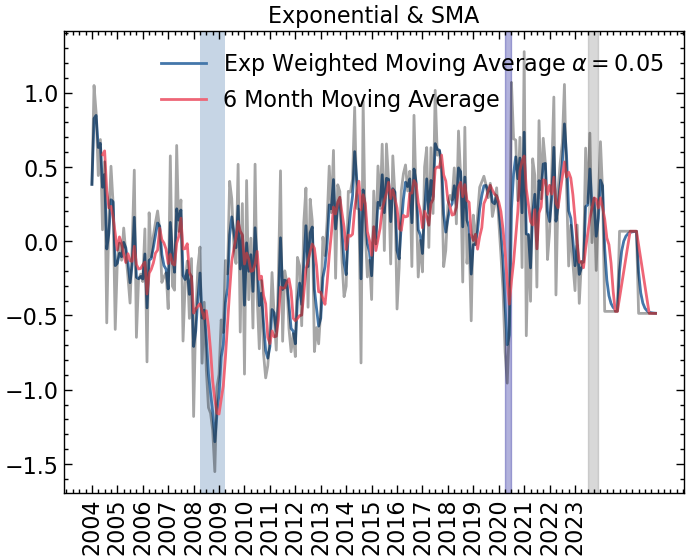

In [74]:

plt.plot(ema, label = r'Exp Weighted Moving Average $\alpha = 0.05$')
plt.plot(sma6, label = '6 Month Moving Average')
plt.plot(std_SI['final'], color = 'black', alpha = 0.35)
plt.axvspan(51, 63, alpha = 0.3)
plt.axvspan(195, 198, alpha = 0.3, color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, color = 'grey')
# plt.suptitle('Alternative Smoothing Processes')
plt.title('Exponential & SMA')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.legend()
plt.show()

## Comments on the graph/Sentiment Index as it stands

## Graphs for dissertation

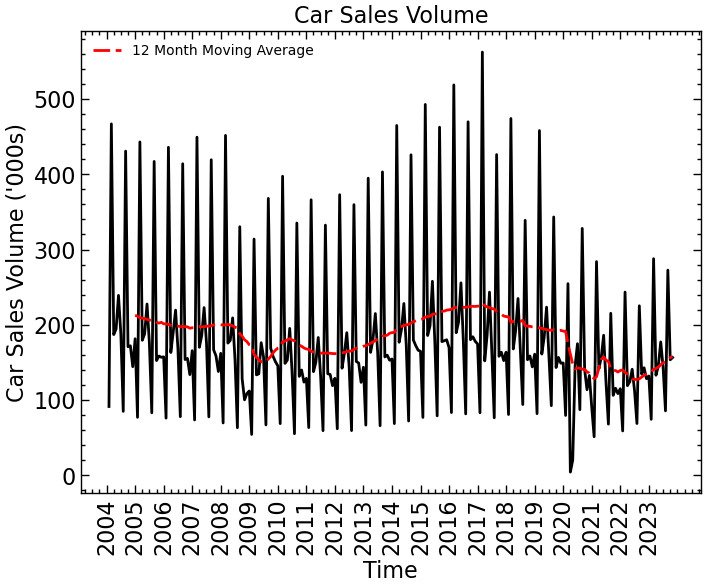

In [75]:
# plot for car sales to illustrate the cyclical/season nature of the variable

indicators['car'] = pd.to_numeric(indicators['car'], errors = 'coerce')


plt.plot(indicators['car'], color = 'black')
plt.plot(indicators['car'].rolling(12).mean(), color = 'red', dashes = [6,2], label = '12 Month Moving Average')
plt.title("Car Sales Volume")
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel("Car Sales Volume ('000s)")
plt.legend(loc = 'upper left', prop = {'size' : 10})
plt.show()

In [76]:
indicators.head()

,Date,period,land_sales_volume,all_vacancies,vacancy_ratio,new_cars,Y10,m7,month,spread,...,period1,month2,car,land,t,month_var,resid_car,resid_land,std_resid_land,std_resid_car
0,01/31/04,2004-01,NaN,2.30,2.4,,,NaN,NaN,NaN,...,2004-01,NaN,NaN,NaN,1,jan,-86.79,NaN,NaN,-3.42
1,02/29/04,2004-02,NaN,2.30,2.3,91.45999999999999,,NaN,NaN,NaN,...,2004-02,NaN,91.46,NaN,2,feb,1.01,NaN,NaN,0.04
2,03/31/04,2004-03,NaN,2.30,2.3,466.96,4.72,NaN,NaN,NaN,...,2004-03,NaN,466.96,NaN,3,mar,-7.34,NaN,NaN,-0.29
3,04/30/04,2004-04,NaN,2.30,2.3,187,4.96,NaN,NaN,NaN,...,2004-04,NaN,187.00,NaN,4,apr,31.26,NaN,NaN,1.23
4,05/31/04,2004-05,NaN,2.40,2.3,194.48,5.11,4.26,4.26,0.85,...,2004-05,4.26,194.48,NaN,5,may,15.21,NaN,NaN,0.60


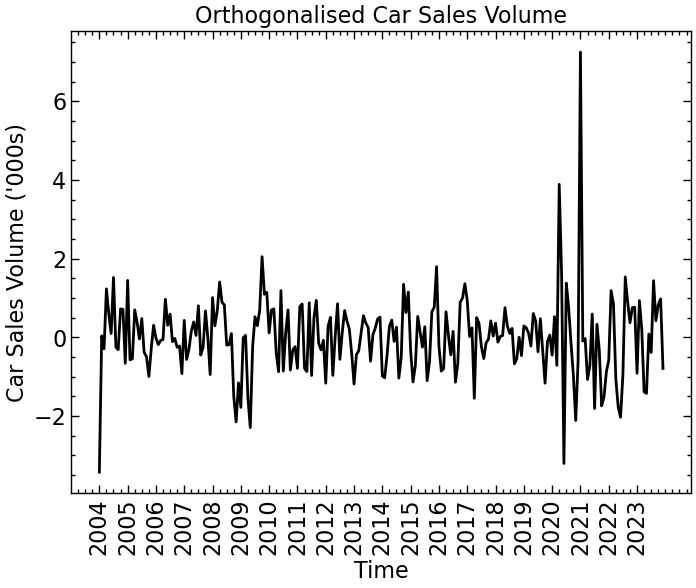

In [77]:
plt.plot(indicators['std_resid_car'], color = 'black')
plt.title("Orthogonalised Car Sales Volume")
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel("Car Sales Volume ('000s)")
plt.show()



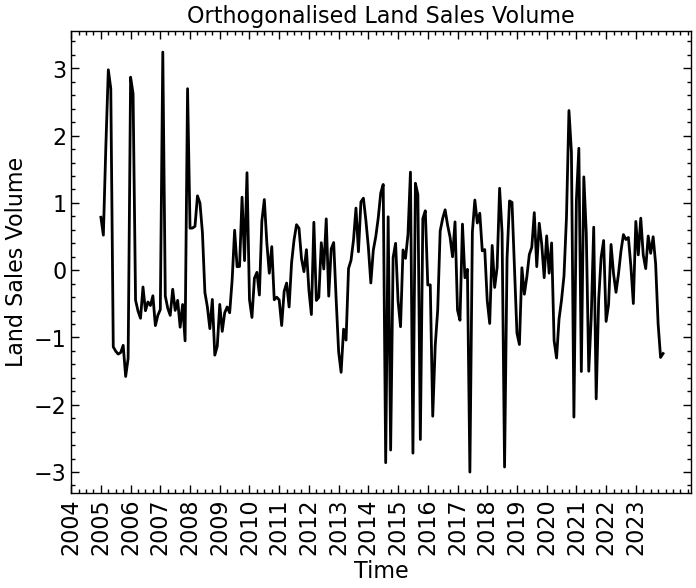

In [78]:
plt.plot(indicators['std_resid_land'], color = 'black')
plt.title("Orthogonalised Land Sales Volume")
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel("Land Sales Volume")
plt.show()


In [79]:
# replacing the NaN values in indicators['land'] with 0
indicators['land'] = pd.to_numeric(indicators['land'], errors = 'coerce')

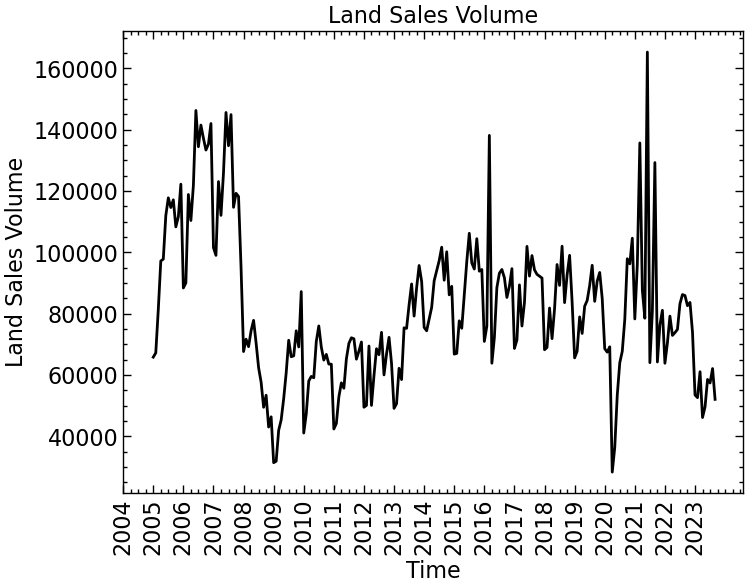

In [80]:
plt.plot(indicators['land'], color = 'black')
plt.title("Land Sales Volume")
plt.xticks(january_indices, labels = years, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel("Land Sales Volume")
plt.show()